In [1]:
import sys 
sys.path.append('..')

from models import DIFDensityEstimator,SoftmaxWeightOver,LocationScaleFlow
from models import EMDensityEstimator
from targets import Target, Uniform
%load_ext autoreload
%autoreload 2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt

tensor([4])


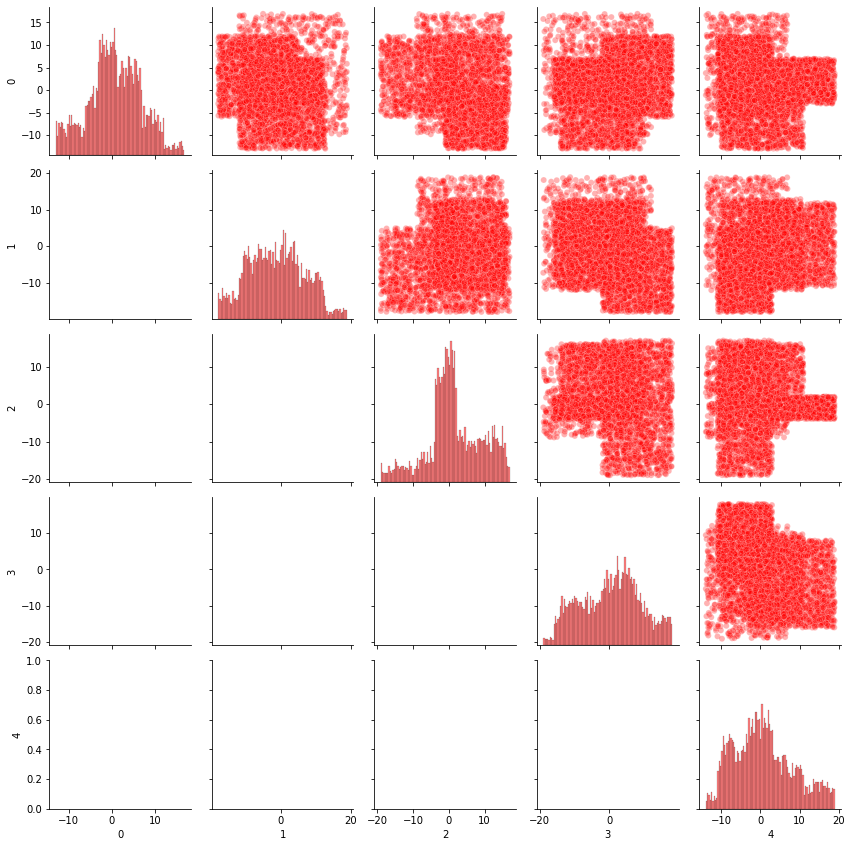

In [35]:
example = "Multimodal Uniform Dimension 64"
num_samples = 10000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.32it/s, loss = 196.95326232910156]


tensor(1.0000, grad_fn=<SumBackward0>)
tensor(196.9533, grad_fn=<NegBackward0>)


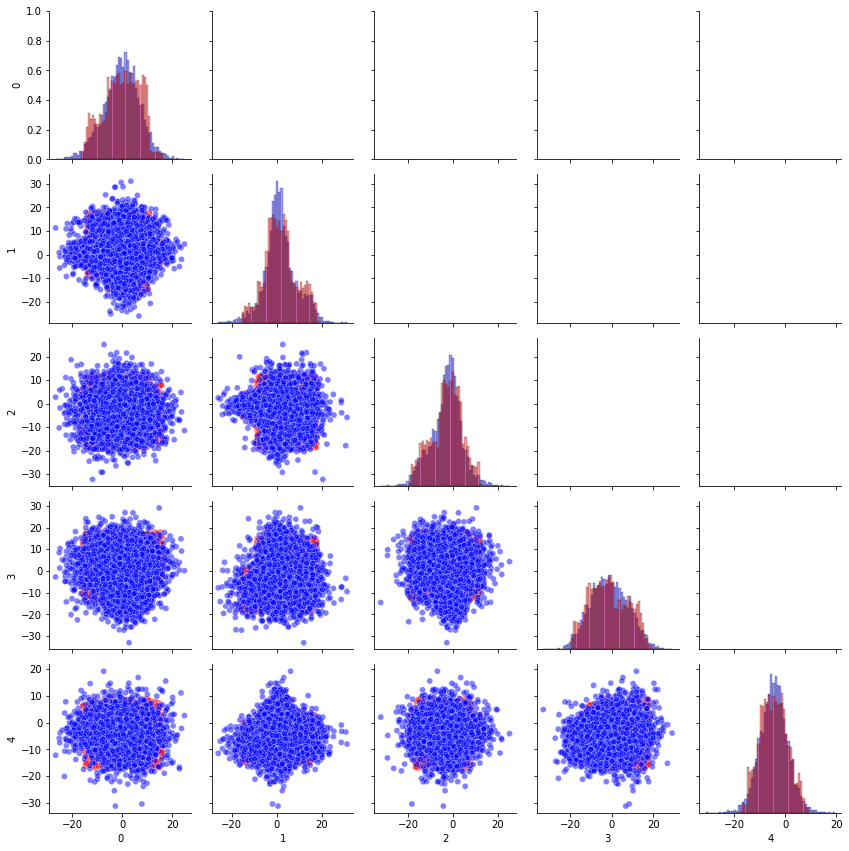

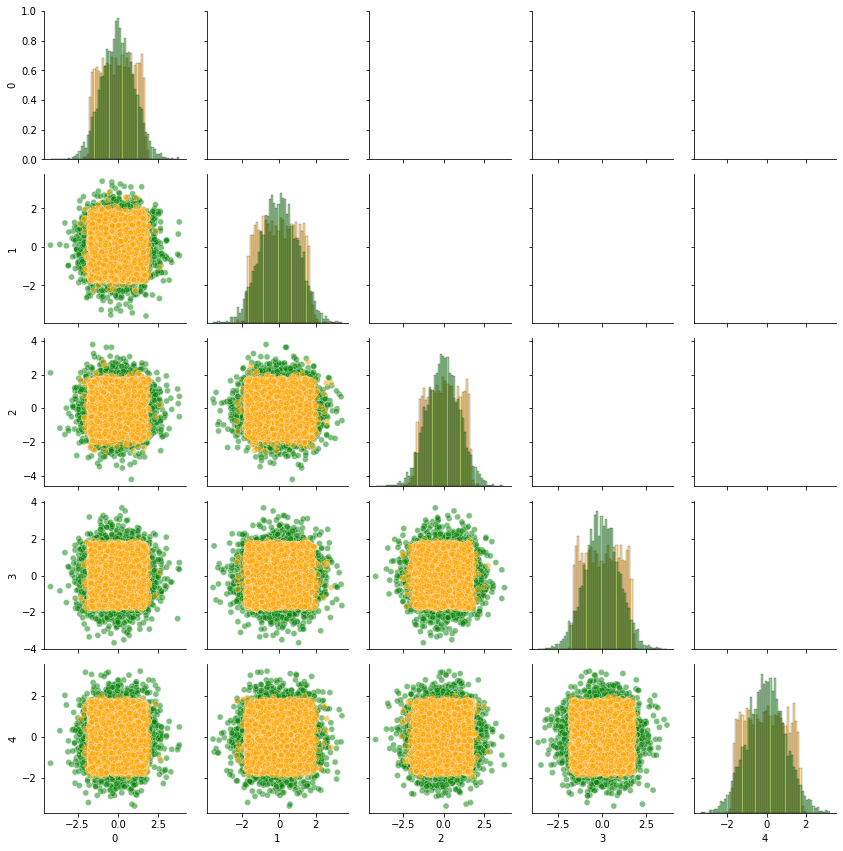

In [48]:
num_samples = target_samples.shape[0]
epochs = 50
K = 20
EM = EMDensityEstimator(target_samples,K)
loss_values = EM.train(epochs,visual=False)
EM.model_visual()
print(-torch.mean(EM.log_density(target_samples)))

In [23]:
print(EM.log_pi)

Parameter containing:
tensor([-2.5051, -1.9260, -2.9216, -3.4481, -4.2043, -3.7149, -1.7176, -3.1817,
        -3.9350, -2.7276, -4.4706, -5.3937, -3.1888, -2.8334, -4.2451, -4.0675,
        -3.5623, -3.4724, -2.3314, -3.2786], requires_grad=True)


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

tensor(195.5858, grad_fn=<NegBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s, loss = 195.21078491210938]


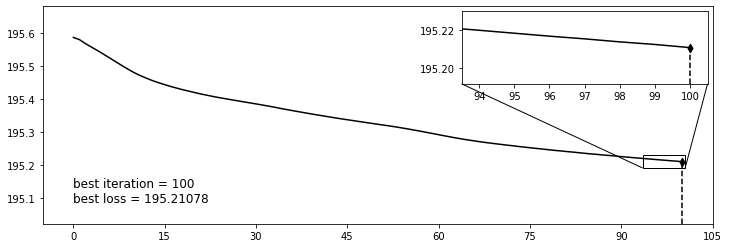

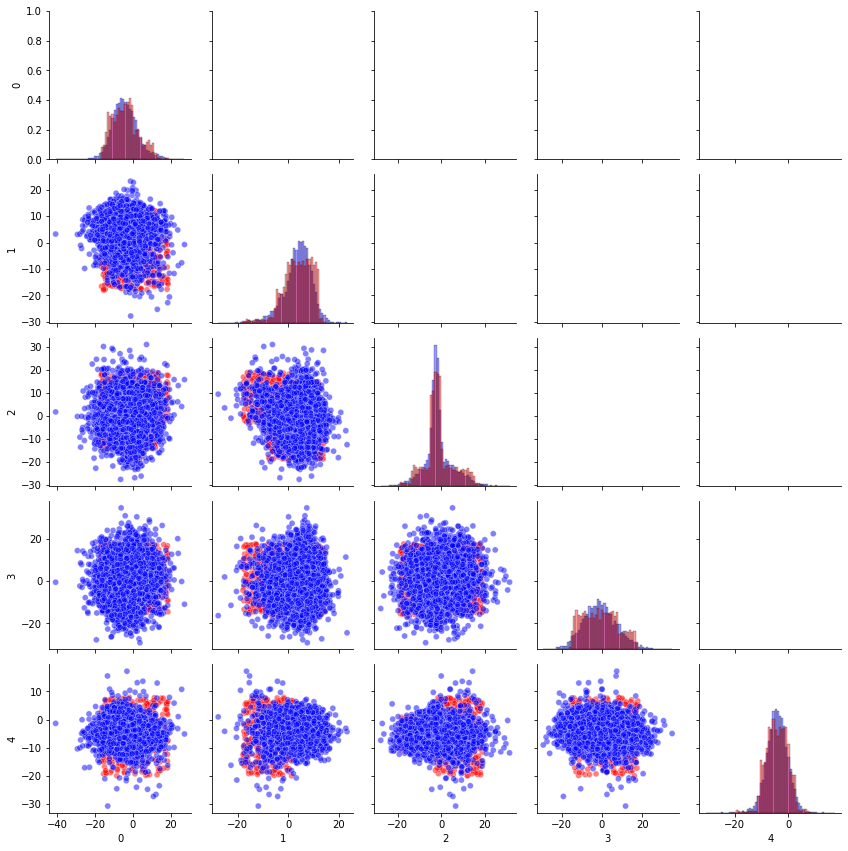

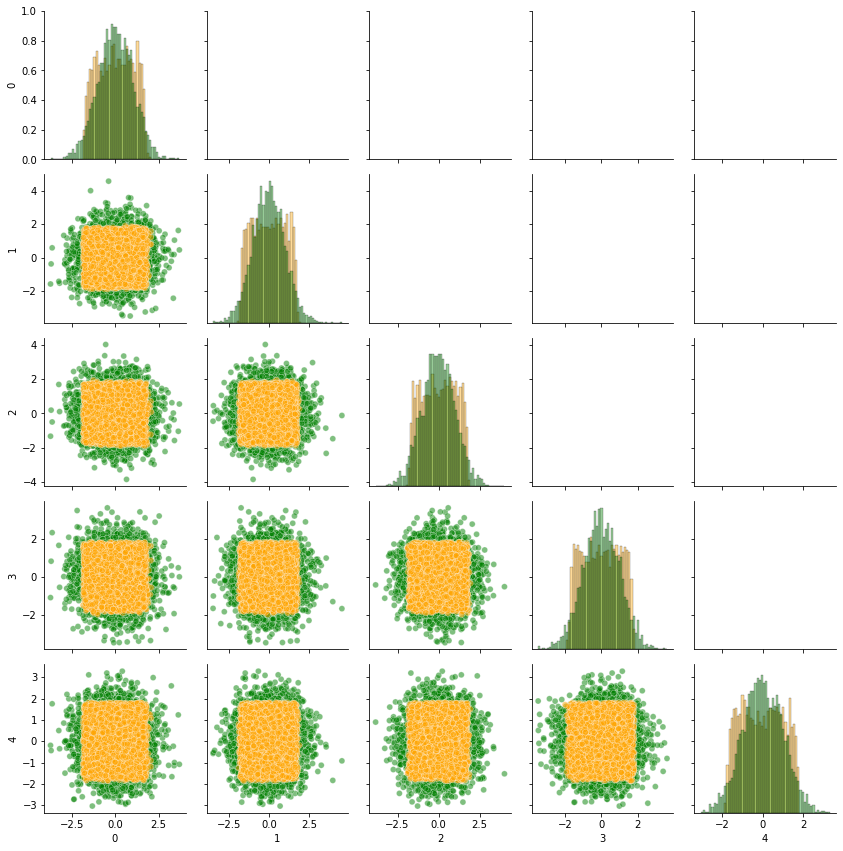

In [25]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 500
K = 20
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, p, [], mode = 'Linear')
initial_w.log_b = nn.Parameter(EM.log_pi)
initial_w.a = nn.Parameter(torch.zeros(K,p))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
print(dif.loss(target_samples, mode ='SGD'))
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

tensor(196.9533, grad_fn=<NegBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:08<00:00, 11.49s/it, loss = 194.404296875]


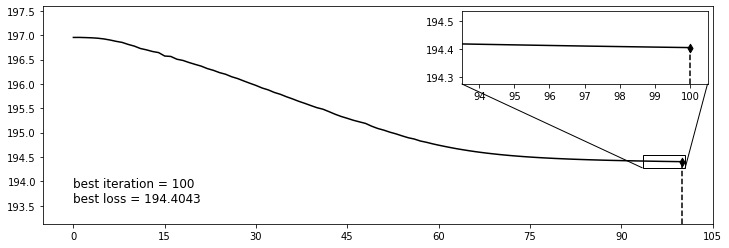

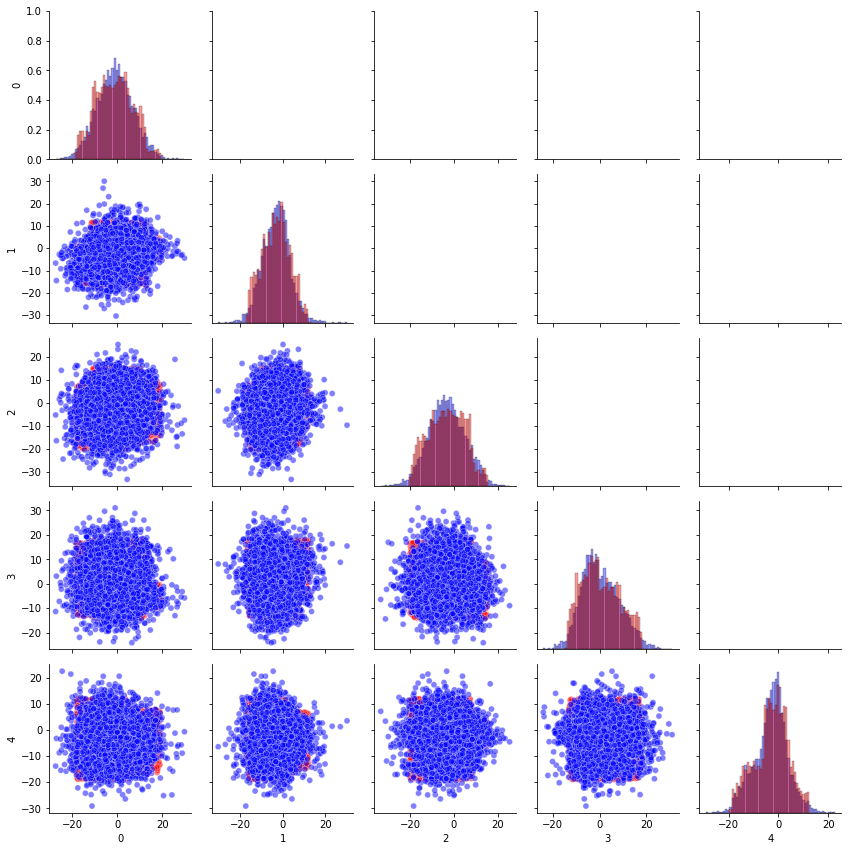

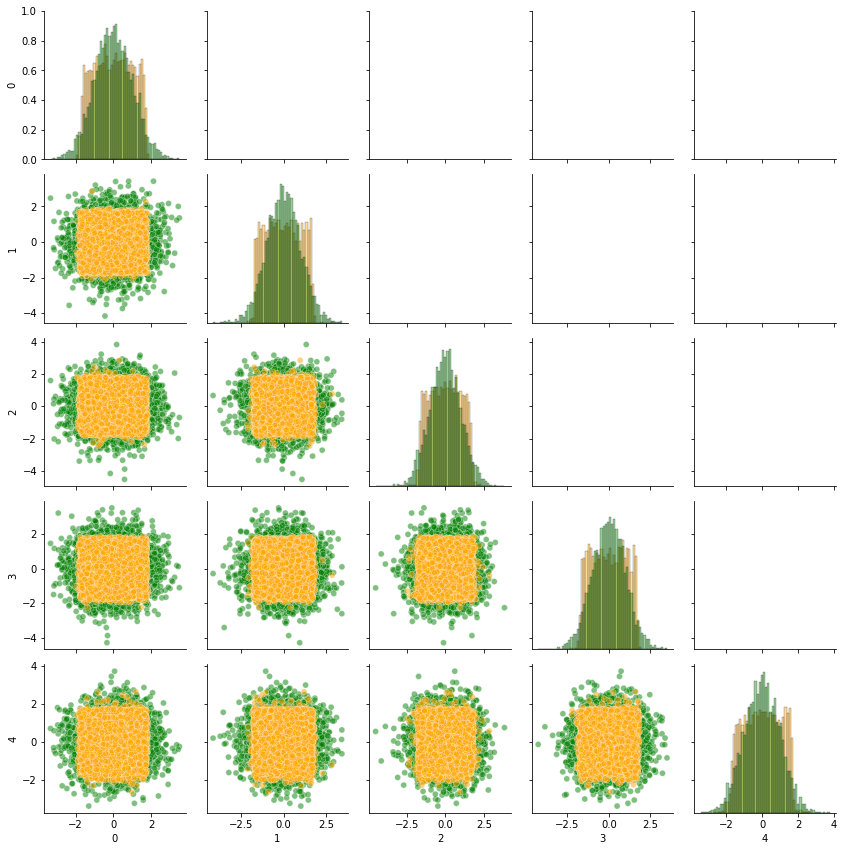

In [49]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = num_samples
K = 20
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, p, [256,256,256], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 256))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_w.a = nn.Parameter(torch.zeros(K,p))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
print(dif.loss(target_samples, mode ='SGD'))
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

In [59]:
z = torch.randn(1000,p)
print(torch.mean(torch.exp(dif.w.log_prob(z)), dim = 0))

tensor([0.0107, 0.0517, 0.0616, 0.0751, 0.0037, 0.0745, 0.0149, 0.0597, 0.0427,
        0.0791, 0.0546, 0.0142, 0.0093, 0.0812, 0.0863, 0.0087, 0.0584, 0.0676,
        0.0411, 0.1048], grad_fn=<MeanBackward1>)


  0%|                                                                                                                                                             | 0/500 [00:00<?, ?it/s]

tensor(2151.0247, grad_fn=<NegBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:55<00:00,  1.41it/s, loss = 218.95291137695312]


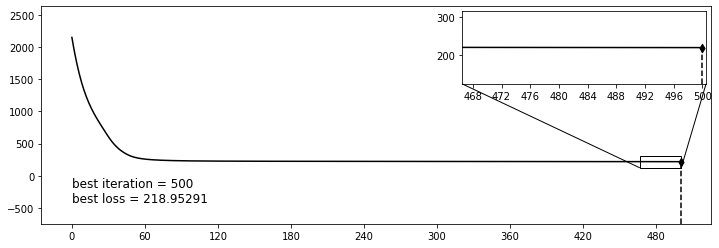

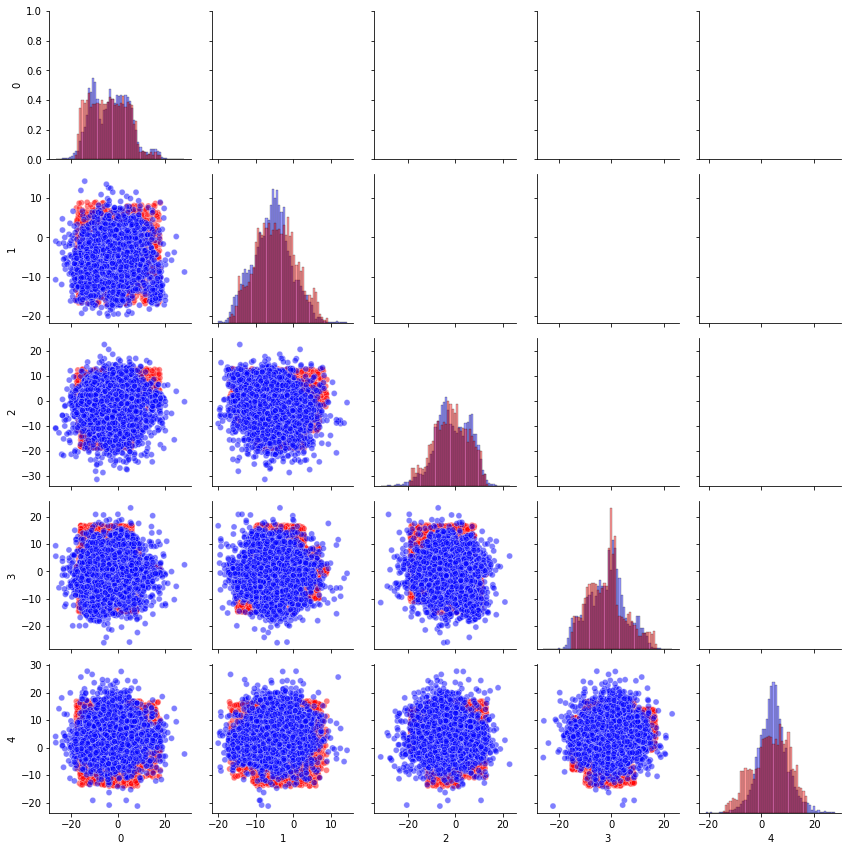

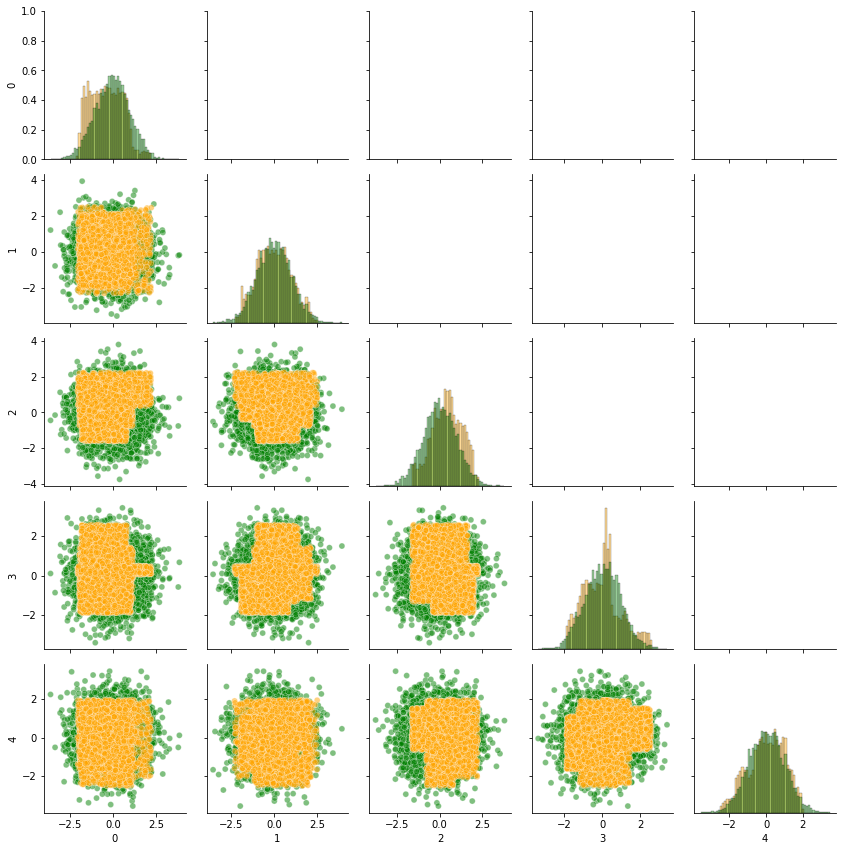

In [64]:
epochs = 500
batch_size = int(num_samples/5)
dif = DIFDensityEstimator(target_samples,K, initial_w = Softmax)
print(dif.loss(target_samples, mode ='SGD'))
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

In [65]:
z = torch.randn(1000,p)
print(torch.mean(torch.exp(dif.w.log_prob(z)), dim = 0))

tensor([0.0012, 0.0202, 0.0337, 0.0264, 0.0250, 0.0474, 0.0220, 0.0264, 0.0292,
        0.0114, 0.0652, 0.0393, 0.0236, 0.0267, 0.0895, 0.0275, 0.0233, 0.3701,
        0.0474, 0.0447], grad_fn=<MeanBackward1>)
